## Tutorial de Modelos Autorregresivos con rezagos distribuidos (ARDL)
En este tutorial conocerás cómo crear modelos de tipo ARDL. El objetivo es el generar este modelo para identificar si existe algun tipo de relacion a corto y largo plazo con las variables de precio de las acciones de amazon. Este tutorial pretende usar la libreria ardl en R, la cual tiene funciones muy utiles para generar el modelo, identificar los multiplicadores a corto y largo plazo y realizar el ARDL basado en la corrección de errores.


**Contenido**
1. [Datos:](#1)
 1. [Datos: Preprocesamiento](#2)
       1. [Importación de librerías requeridas](#3)
       1. [Descarga de datos financieros](#4)
       1. [Generación de formato ts](#5)
       1. [Visualización de las series de interés](#6)
       1. [Prueba de estacionariedad](#7)
1. [Modelos ARDL](#8)
    1. [Predicción](#8a)
    1. [Bound test para la verificacion de relaciones a largo y corto termino](#9)
    1. [Mutiplicadores de largo y corto termino](#10)


<a id="1"></a> <br>
## 1. Datos y Modelamiento

<a id="2"></a> <br>
#### A. Datos: Preprocesamiento

Esta sección básicamente involucra desde la descarga de los datos financieros y eliminación de datos faltantes, su visualización, adecuado formato de series de tiempo; que son procesos necesarios previos al modelamiento.

<a id="3"></a> <br>
##### a. Importación de librerías requeridas

A continuación, importaremos las librerías necesarias. Estos paquetes comprenden aquellos para la descarga y manipulación de datos financieros, para la visualización y el modelamiento. En la segunda parte de este tutorial, llamaremos otras librerías que serán útiles para el pronóstico futuro.

In [4]:
# Actualizamos la versión de R en Kaggle, así como algunas versiones de depaendencias de la paquetería ARDL. Este proceso es tardado.
#install.packages("CCA")
devtools::install_version("pbkrtest", version = "0.5.1")

stringi   (1.8.4     -> 1.8.7    ) [CRAN]
RcppEigen (0.3.4.0.0 -> 0.3.4.0.2) [CRAN]
nloptr    (2.0.3     -> 2.2.1    ) [CRAN]
minqa     (1.2.7     -> 1.2.8    ) [CRAN]


Installing 4 packages: stringi, RcppEigen, nloptr, minqa

Installing packages into ‘/Users/U1037319/Library/R/arm64/4.2/library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘RcppEigen’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘nloptr’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘minqa’ had non-zero exit status”
Installing package into ‘/Users/U1037319/Library/R/arm64/4.2/library’
(as ‘lib’ is unspecified)



In [5]:
#install.packages("devtools")
devtools::install_github("Natsiopoulos/ARDL")

Using GitHub PAT from the git credential store.




Error in utils::download.file(url, path, method = method, quiet = quiet,  : 
  download from 'https://api.github.com/repos/Natsiopoulos/ARDL/tarball/HEAD' failed


In [6]:
### Para el modelado
library(ARDL)

In [7]:
#Otros de manipulación de datos
library(tidyverse) 
library(fields)  
library(forecast)  
library(quantmod) 
library(dygraphs) 
library(dplyr)    
library(ggplot2) 
library(tseries)   
library(tidyverse)   
library(urca)
library(TSstudio)
theme_set(theme_bw())
options(warn = - 1) 

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.4
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the


<a id="4"></a> <br>
##### b. Descarga de datos
Descargamos una base con 5 variables cuyo periodo se encuentra entre 1974:Q1 y 1987:Q3.


In [8]:
#Datos:
data(denmark)
str(denmark)
# LRM: logarithm of real money, M2
# LRY: logarithm of real income
# LPY: logarithm of price deflator
# IBO: bond rate
# IDE: bank deposit rate

'data.frame':	55 obs. of  6 variables:
 $ ENTRY: Factor w/ 55 levels "1974:01","1974:02",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ LRM  : num  11.6 11.6 11.6 11.6 11.6 ...
 $ LRY  : num  5.9 5.87 5.84 5.81 5.8 ...
 $ LPY  : num  -0.619 -0.581 -0.543 -0.505 -0.486 ...
 $ IBO  : num  0.155 0.178 0.171 0.152 0.134 ...
 $ IDE  : num  0.094 0.0955 0.0955 0.0955 0.0885 0.079 0.076 0.074 0.072 0.078 ...


In [9]:
# Podemos imprimir las series.
tail(denmark)
length(denmark)

,ENTRY,LRM,LRY,LPY,IBO,IDE
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
50,1986:02,12.07546,6.089658,0.4130280,0.0984000,0.06745833
51,1986:03,12.05619,6.098992,0.4182679,0.1115000,0.06794079
52,1986:04,12.07163,6.080706,0.4282964,0.1142670,0.07539570
53,1987:01,12.02795,6.061175,0.4467611,0.1193333,0.07665326
54,1987:02,12.03979,6.063730,0.4583306,0.1173333,0.07625867
55,1987:03,12.01529,6.050830,0.4683345,0.1189667,0.07516289


[1] 6

<a id="5"></a> <br>
##### c. Generación de formato ts.

In [10]:
#Ya que tenemos que trabajar en formato ts, transformamos la serie con frecuencia trimestral.
y <- ts(denmark$LRM, start = c(1974,1), frequency = 4)
ri <- ts(denmark$LRY, start = c(1974,1), frequency = 4)
pd <- ts(denmark$LPY, start = c(1974,1), frequency = 4)
br <- ts(denmark$IBO, start = c(1974,1), frequency = 4)
dr <- ts(denmark$IDE, start = c(1974,1), frequency = 4)


In [26]:
y

,Qtr1,Qtr2,Qtr3,Qtr4
1974,11.63255,11.60415,11.58152,11.60185
1975,11.58630,11.60450,11.65331,11.76425
1976,11.75293,11.76548,11.78058,11.77018
1977,11.74589,11.76865,11.74982,11.74870
1978,11.70492,11.70344,11.70300,11.70367
1979,11.67890,11.70778,11.67616,11.68592
1980,11.64161,11.63518,11.60926,11.65761
1981,11.62782,11.62885,11.60378,11.62906
1982,11.60202,11.60378,11.59462,11.60382
1983,11.61713,11.68810,11.72651,11.78125


<a id="6"></a> <br>
##### d. Visualización de las series de interés

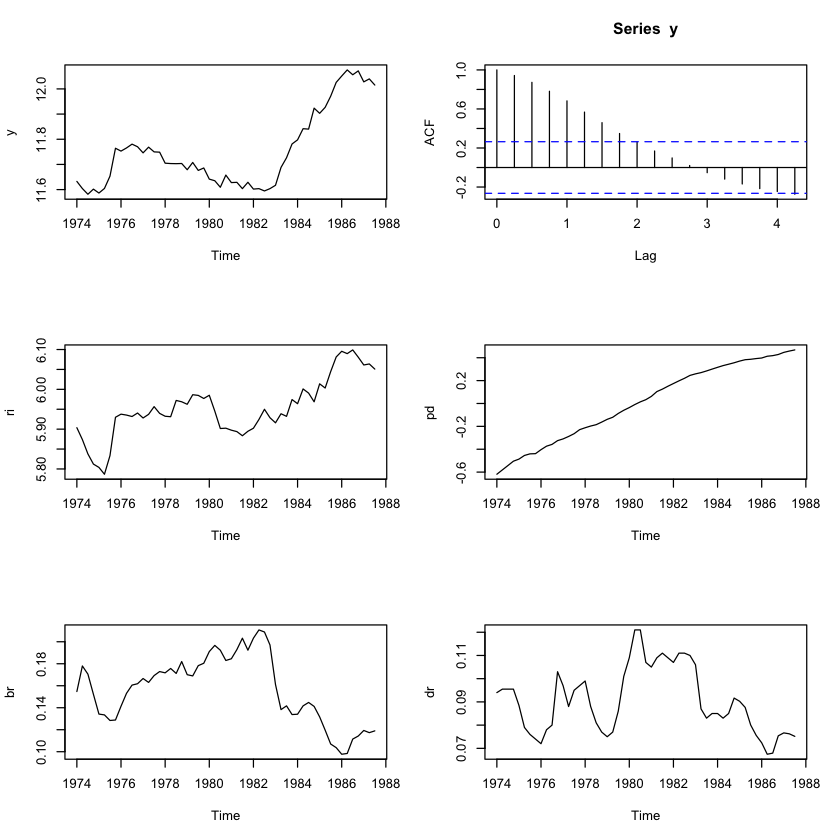

In [11]:
#Podemos  visualizar la serie de tiempo y confirmar que la variable de respuesta no es estacionaria (mediante el acf)
par(mfrow=c(3,2))
ts.plot(y)
acf(y)
ts.plot(ri)
ts.plot(pd)
ts.plot(br)
ts.plot(dr)

<a id="7"></a> <br>
##### d. Prueba de estacionariedad

In [12]:
# Comprobemos que las series no son estacionarias. 
library(fUnitRoots)
adfTest(y)
adfTest(ri)
adfTest(pd)
adfTest(br)
adfTest(dr)


Attaching package: ‘fUnitRoots’


The following objects are masked from ‘package:urca’:

    punitroot, qunitroot, unitrootTable





Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: 1.5601
  P VALUE:
    0.968 

Description:
 Thu May 15 17:02:03 2025 by user: 


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: 0.7944
  P VALUE:
    0.8635 

Description:
 Thu May 15 17:02:03 2025 by user: 


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -0.3476
  P VALUE:
    0.5009 

Description:
 Thu May 15 17:02:03 2025 by user: 


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -0.982
  P VALUE:
    0.2994 

Description:
 Thu May 15 17:02:03 2025 by user: 


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -0.6543
  P VALUE:
    0.4035 

Description:
 Thu May 15 17:02:03 2025 by user: 

<a id="8"></a> <br>
## 2. Construcción modelo ARDL
Una de las caracteristicas de este paquete, siendo una gran ventaja, es que no requiere de tanto procesamiento de las series de tiempo. Por tal motivo una vez se realiza la partición de los datos podemos entrenar el modelo. Es decir, al especificar el orden p y q para las variables, la funciión internamente genera los lags de estas.

In [14]:
#Se realiza una búsqueda tipo grid search:
#Selección automatica:
library(ARDL)
models <- auto_ardl(LRM ~ LRY +IBO + IDE, data = denmark, max_order = 6)

In [15]:
#Revisemos el top 20 de los mejores modelos según su critrio de información de Akaike
models$top_orders

LRM,LRY,IBO,IDE,AIC
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,3,2,-251.0259
3,1,3,3,-250.1144
2,2,0,0,-249.6266
3,2,3,2,-249.1087
5,4,3,5,-249.0276
3,2,3,3,-248.1858
5,3,3,5,-247.8138
2,2,0,1,-247.7786
2,1,0,0,-247.5643


In [16]:
#Procedemos a construir el modelo de regresión con la mejor combinación.
mod1 <- ardl(LRM ~ LRY +IBO + IDE, data = denmark, order = c(3,1,3,2))
summary(mod1)


Time series regression with "ts" data:
Start = 4, End = 55

Call:
dynlm::dynlm(formula = full_formula, data = data, start = start, 
    end = end)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.029939 -0.008856 -0.002562  0.008190  0.072577 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.6202     0.5678   4.615 4.19e-05 ***
L(LRM, 1)     0.3192     0.1367   2.336 0.024735 *  
L(LRM, 2)     0.5326     0.1324   4.024 0.000255 ***
L(LRM, 3)    -0.2687     0.1021  -2.631 0.012143 *  
LRY           0.6728     0.1312   5.129 8.32e-06 ***
L(LRY, 1)    -0.2574     0.1472  -1.749 0.088146 .  
IBO          -1.0785     0.3217  -3.353 0.001790 ** 
L(IBO, 1)    -0.1062     0.5858  -0.181 0.857081    
L(IBO, 2)     0.2877     0.5691   0.505 0.616067    
L(IBO, 3)    -0.9947     0.3925  -2.534 0.015401 *  
IDE           0.1255     0.5545   0.226 0.822161    
L(IDE, 1)    -0.3280     0.7213  -0.455 0.651847    
L(IDE, 2)     1.4079     0.5520   

In [17]:
# Para la interpretación, podemos imprimir los rezagos correspondientes de cada variable que explican la respuesta. Esto no indica que sean I(d), sino el número de rezagos que logran una corrección al error.
mod1$full_formula

LRM ~ L(LRM, 1) + L(LRM, 2) + L(LRM, 3) + LRY + L(LRY, 1) + IBO + 
    L(IBO, 1) + L(IBO, 2) + L(IBO, 3) + IDE + L(IDE, 1) + L(IDE, 
    2)

In [18]:
## Un segundo modelo podría contemplar la tendencia, porque Y tenia tendencia:
mod1_ten <- ardl(LRM ~ LRY + IBO + IDE + trend(LRM),data = denmark, order = c(3,1,3,2))
summary(mod1_ten)


Time series regression with "ts" data:
Start = 4, End = 55

Call:
dynlm::dynlm(formula = full_formula, data = data, start = start, 
    end = end)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.027980 -0.008191 -0.003837  0.007566  0.067133 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.2776467  0.7444909   4.403 8.41e-05 ***
trend(LRM)   0.0005111  0.0003797   1.346 0.186188    
L(LRM, 1)    0.3007878  0.1359454   2.213 0.033010 *  
L(LRM, 2)    0.5298313  0.1310197   4.044 0.000248 ***
L(LRM, 3)   -0.2581059  0.1013909  -2.546 0.015086 *  
LRY          0.6246934  0.1346464   4.640 4.07e-05 ***
L(LRY, 1)   -0.2971209  0.1486208  -1.999 0.052777 .  
IBO         -0.9749049  0.3275711  -2.976 0.005055 ** 
L(IBO, 1)   -0.1343780  0.5801669  -0.232 0.818076    
L(IBO, 2)    0.3423639  0.5647277   0.606 0.547956    
L(IBO, 3)   -1.0664899  0.3921338  -2.720 0.009797 ** 
IDE         -0.0059852  0.5573841  -0.011 0.991489    
L(IDE, 1

Como podemos ver, este segundo modelo genera un mejor resultado, medido por R cuadrado ajustado. 

<a id="8a"></a> <br>
### Predicción
Procedemos ahora con la predicción del modelo.

   Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
56       11.99975 11.96199 12.03751 11.94201 12.05750
57       11.98877 11.93059 12.04696 11.89978 12.07776
58       11.97999 11.89984 12.06014 11.85740 12.10258
59       11.97296 11.87051 12.07541 11.81628 12.12965
60       11.96734 11.84284 12.09185 11.77693 12.15776

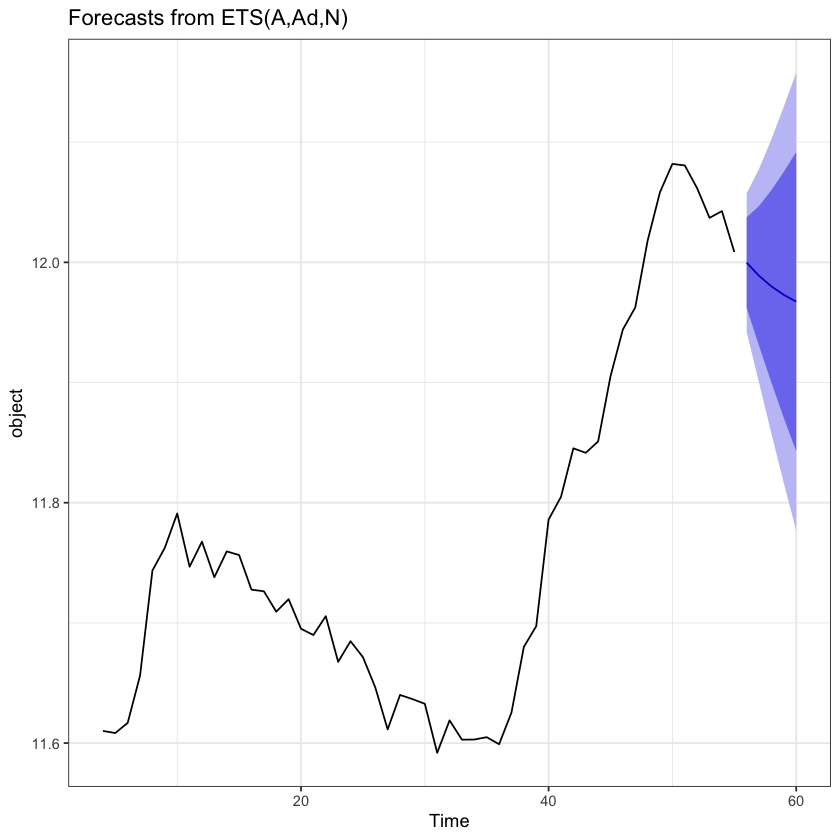

In [19]:
##Predicción del primer modelo sin tendencia:
stats::predict(mod1$fitted.values, h=5)
autoplot(predict(mod1$fitted.values, h=5))

<a id="9"></a> <br>
#### A. Bound test para la verificacion de relaciones a largo termino
Esta prueba basada en la prueba de hipotesis de Wald, evalua si los coeficientes de rezagos son iguales a cero, o de lo contrario existe evidencia que alguno de ellos es diferente de cero (Pesaran et al. (2001)).

In [20]:
#Guardamos el mejor modelo obtenido en la sección anterior
modelo <- models$best_model
#Realizamos la prueba de hipotesis
bounds_f_test(modelo, case = 2) # el parametro "case" igual a 2 verifica si existe relaciones a largo termino, con la combinación de (restricted constant, no linear trend).


	Bounds F-test (Wald) for no cointegration

data:  d(LRM) ~ L(LRM, 1) + L(LRY, 1) + L(IBO, 1) + L(IDE, 1) + d(L(LRM,     1)) + d(L(LRM, 2)) + d(LRY) + d(IBO) + d(L(IBO, 1)) + d(L(IBO,     2)) + d(IDE) + d(L(IDE, 1))
F = 5.1168, p-value = 0.004418
alternative hypothesis: Possible cointegration
null values:
   k    T 
   3 1000 


In [21]:
#Realizamos la prueba de hipotesis para el modelo con tendencia
bounds_f_test(mod1_ten, case = 4) # el parametro "case" igual a 4 implica (unrestricted constant, linear trend)


	Bounds F-test (Wald) for no cointegration

data:  d(LRM) ~ trend(LRM) + L(LRM, 1) + L(LRY, 1) + L(IBO, 1) + L(IDE,     1) + d(L(LRM, 1)) + d(L(LRM, 2)) + d(LRY) + d(IBO) + d(L(IBO,     1)) + d(L(IBO, 2)) + d(IDE) + d(L(IDE, 1))
F = 5.4306, p-value = 0.007069
alternative hypothesis: Possible cointegration
null values:
   k    T 
   3 1000 


A partir de los resultados anteriores, podemos confirmar que existe una relacion a largo plazo entre los activos.

<a id="10"></a> <br>
#### B. Mutiplicadores de largo y corto termino
Cuando revisamos los coeficientes de un modelo de regresión lineal, sabemos que existe un cambio en Y por un cambio de una unidad de X. Como revisamos en la lectura, los multiplicadores son la suma de los coeficientes a largo o corto termino. En este sentido podemos calcular los multiplicadores usando la siguiente función:

In [22]:
#Multiplicadores a corto plazo
multipliers(modelo, type = "sr")

,Term,Estimate,Std. Error,t value,Pr(>|t|)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),2.6201916,0.5677679,4.6148990,4.186867e-05
2,LRY,0.6727993,0.1311638,5.1294603,8.317401e-06
3,IBO,-1.0785180,0.3217011,-3.3525465,1.790030e-03
4,IDE,0.1254643,0.5544522,0.2262852,8.221614e-01


A partir de estos resultados podemos concluir que, por ejemplo, un cambio marginal en LRY manteniendo constantes los demás valores, genera un cambio en el corto plazo o inmediato de 0.6 unidades en la respuesta, LRM.

In [23]:
#Multiplicadores a largo plazo
multipliers(modelo)

ERROR: Error in loadNamespace(x): there is no package called ‘msm’


Podemos derivar conclusiones similares a las de multiplicadores de corto plazo. Por ejemplo, un cambio marginal en IBO manteniendo constantes los demás valores, genera un cambio en -4.5 unidades en LRM en el largo plazo.

En este tutorial aprendimos del modelo autorregresivo con rezagos distribuidos. Este modelo ampliamente usado por economistas ayuda a incorporar variables exogenas que permitan mejorar la predicción y la inferencia de una serie de tiempo. En este caso vimos cómo la serie de SPY se puede explicar con diversos activos, incluyendo sus rezagos.